# 4D change analysis of near-continuous LiDAR time series for applications in geomorphic monitoring

## Time series-based change analysis of surface dynamics using PCA

In this notebook we will perform time series-based surface change analysis on a time series of permanent TLS point clouds of the sandy beach at Kijkduin for a timespan of around 6 months (<a href="#references">Vos et al., 2022</a>). An introduction to the case study and dataset can be found [here](https://3dgeo-heidelberg.github.io/etrainee/module3/06_casestudy_sandybeach/06_casestudy_sandybeach.html). 

The objective is to assess surface dynamics using Principal Component Analysis (PCA; following Frantzen et al., 2023). Look into the related article for comparison of possible surface dynamics of the use case and help for deciding on suitable parameters, etc.

The workflow is  introduced throughout this notebook. Also, make use of the software documentations!

## Software and data
This task is solved using Python with the [`py4dgeo`](https://github.com/3dgeo-heidelberg/py4dgeo) library. 

You can use CloudCompare or GIS Software (e.g. QGIS) to check the data and visualize your results.

The dataset is a subsampled version of the original time series, using 12-hourly epochs of point clouds and spatial subsampling to 50 cm. The dataset [can be downloaded](https://zenodo.org/records/10003575) (module3.zip) from the E-learning course E-TRAINEE. In the data directory `kijkduin`, you find the prepared input point clouds and a core points point cloud, which is manually cleaned from noise.

[E-TRAINEE](https://github.com/3dgeo-heidelberg/etrainee) is an e-learning course on Time Series Analysis in Remote Sensing for Understanding Human-Environment Interactions. This course has been developed by research groups from four partner universities – Charles University, Heidelberg University, University of Innsbruck, and University of Warsaw.

## Loading data and calculation of surface changes

Prepare the analysis by compiling the list of files (epochs) and read the timestamps from the file names (format `YYMMDD_hhmmss`) into `datetime` objects. Use the point cloud files and timestamps to create a py4dgeo `SpatiotemporalAnalysis` object. For this you need to instantiate the M3C2 algorithm. You can use the point cloud file `170115_150816_aoi_50cm.laz` as core points. Explore the point cloud properties in CloudCompare: 

* Considering the available point density and surface characteristics, what would be a suitable cylinder radius for the distance calculation?
* What would be a suitable approach to derive the surface normals in this topography and expected types of surface changes?

Hint: In this flat topography and predominant provess of sand deposition and erosion, it can be suitable to orient the normals purely vertically. In this case, they do not need to be computed, and you can [customize the py4dgeo algorithm](https://py4dgeo.readthedocs.io/en/latest/customization.html#Changing-search-directions) accordingly.

Use the first point cloud in the time series (list of files) as reference epoch. You can assume a registration error of 1.9 cm for the M3C2 distance calculation (cf. <a href="#references">Vos et al., 2022</a>).

Explore the spatiotemporal change information by visualizing the changes at a selected epoch and visualizing the time series at a selected location. 

First, we start by setting up the Python environment and data:

In [1]:
# import required modules
import py4dgeo
import os
import numpy as np
from datetime import datetime
import pooch

# Download data from zenodo and set path to point cloud folder
p = pooch.Pooch(base_url="doi:10.5281/zenodo.10003574/", path=pooch.os_cache("py4dgeo"))
p.load_registry_from_doi()
p.fetch("module3.zip", processor=pooch.Unzip())
pc_dir = os.path.join(p.path, "module3.zip.unzip/module3/kijkduin", "pointclouds")

# Remove zip file if it exists from previous executions of the notebook
unwanted_file = os.path.join(pc_dir, "kijkduin.zip")
if os.path.exists(unwanted_file):
    os.remove(unwanted_file)

# list of point clouds (time series)
pc_list = os.listdir(pc_dir)
pc_list[:5]  # print the first elements

['kijkduin_170117_120041.laz',
 'kijkduin_170118_000050.laz',
 'kijkduin_170120_120036.laz',
 'kijkduin_170121_000046.laz',
 'kijkduin_170121_120055.laz']

In the list of point cloud files you can see that we have one laz file per epoch available. The file name contains the timestamp of the epoch, respectively, in format `YYMMDD_hhmmss`. To use this information for our analysis, we read the timestamp information from the file names into `datetime` objects.

In [2]:
# read the timestamps from file names
timestamps = []
for f in pc_list:
    if not f.endswith(".laz"):
        continue

    # get the timestamp from the file name
    timestamp_str = "_".join(f.split(".")[0].split("_")[1:])  # yields YYMMDD_hhmmss

    # convert string to datetime object
    timestamp = datetime.strptime(timestamp_str, "%y%m%d_%H%M%S")
    timestamps.append(timestamp)

timestamps[:5]

[datetime.datetime(2017, 1, 17, 12, 0, 41),
 datetime.datetime(2017, 1, 18, 0, 0, 50),
 datetime.datetime(2017, 1, 20, 12, 0, 36),
 datetime.datetime(2017, 1, 21, 0, 0, 46),
 datetime.datetime(2017, 1, 21, 12, 0, 55)]

Now we use the point cloud files and timestamp information to create a `SpatiotemporalAnalysis` object.

In [3]:
analysis = py4dgeo.SpatiotemporalAnalysis(f"{pc_dir}/kijkduin.zip", force=True)

[2023-12-01 14:11:11][INFO] Creating analysis file C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds/kijkduin.zip


As reference epoch, we use the first epoch in our time series:

In [4]:
# specify the reference epoch
reference_epoch_file = os.path.join(pc_dir, pc_list[0])

# read the reference epoch and set the timestamp
reference_epoch = py4dgeo.read_from_las(reference_epoch_file)
reference_epoch.timestamp = timestamps[0]

# set the reference epoch in the spatiotemporal analysis object
analysis.reference_epoch = reference_epoch

[2023-12-01 14:11:11][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170117_120041.laz'
[2023-12-01 14:11:11][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:11][INFO] Saving epoch to file 'C:\Users\ep413\AppData\Local\Temp\tmpof6ztayy\reference_epoch.zip'
[2023-12-01 14:11:11][INFO] Saving a file without normals.


For epochs to be added, we now configure the M3C2 algorithm to derive the change values. We would like to set the normals purely vertically, so we define a customized computation of cylinder `directions`:

In [5]:
# Inherit from the M3C2 algorithm class to define a custom direction algorithm
class M3C2_Vertical(py4dgeo.M3C2):
    def directions(self):
        return np.array([0, 0, 1])  # vertical vector orientation


# specify corepoints, here all points of the reference epoch
analysis.corepoints = reference_epoch.cloud[::]

# specify M3C2 parameters for our custom algorithm class
analysis.m3c2 = M3C2_Vertical(
    cyl_radii=(1.0,), max_distance=10.0, registration_error=0.019
)

[2023-12-01 14:11:11][INFO] Initializing Epoch object from given point cloud
[2023-12-01 14:11:11][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:11][INFO] Saving epoch to file 'C:\Users\ep413\AppData\Local\Temp\tmpefqey9ch\corepoints.zip'
[2023-12-01 14:11:11][INFO] Saving a file without normals.


Now we add all the other epochs with their timestamps:

In [6]:
# create a list to collect epoch objects
epochs = []
for e, pc_file in enumerate(pc_list[1:]):
    epoch_file = os.path.join(pc_dir, pc_file)
    epoch = py4dgeo.read_from_las(epoch_file)
    epoch.timestamp = timestamps[e]
    epochs.append(epoch)

# add epoch objects to the spatiotemporal analysis object
analysis.add_epochs(*epochs)

# print the spatiotemporal analysis data for 3 corepoints and 5 epochs, respectively
print(f"Space-time distance array:\n{analysis.distances[:3,:5]}")
print(
    f"Uncertainties of M3C2 distance calculation:\n{analysis.uncertainties['lodetection'][:3, :5]}"
)
print(f"Timestamp deltas of analysis:\n{analysis.timedeltas[:5]}")

[2023-12-01 14:11:12][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170118_000050.laz'
[2023-12-01 14:11:12][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170120_120036.laz'
[2023-12-01 14:11:12][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170121_000046.laz'
[2023-12-01 14:11:12][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170121_120055.laz'
[2023-12-01 14:11:12][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170123_120045.laz'
[2023-12-01 14:11:12][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:11:13][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170306_000043.laz'
[2023-12-01 14:11:13][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170306_120051.laz'
[2023-12-01 14:11:13][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170307_000058.laz'
[2023-12-01 14:11:13][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170308_120026.laz'
[2023-12-01 14:11:13][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170309_000036.laz'
[2023-12-01 14:11:13][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:11:14][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170416_120029.laz'
[2023-12-01 14:11:14][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170417_000037.laz'
[2023-12-01 14:11:14][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170417_120047.laz'
[2023-12-01 14:11:14][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170418_120004.laz'
[2023-12-01 14:11:14][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170419_000013.laz'
[2023-12-01 14:11:14][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:11:15][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170511_000043.laz'
[2023-12-01 14:11:16][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170512_000002.laz'
[2023-12-01 14:11:16][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170512_120011.laz'
[2023-12-01 14:11:16][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170513_000019.laz'
[2023-12-01 14:11:16][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170513_120030.laz'
[2023-12-01 14:11:16][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:11:21][INFO] Starting: Adding epoch 16/159 to analysis object
[2023-12-01 14:11:21][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:21][INFO] Finished in 0.3269s: Adding epoch 16/159 to analysis object
[2023-12-01 14:11:21][INFO] Starting: Adding epoch 17/159 to analysis object
[2023-12-01 14:11:21][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:22][INFO] Finished in 0.3279s: Adding epoch 17/159 to analysis object
[2023-12-01 14:11:22][INFO] Starting: Adding epoch 18/159 to analysis object
[2023-12-01 14:11:22][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:22][INFO] Finished in 0.3225s: Adding epoch 18/159 to analysis object
[2023-12-01 14:11:22][INFO] Starting: Adding epoch 19/159 to analysis object
[2023-12-01 14:11:22][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:22][INFO] Finished in 0.3426s: Adding epoch 19/159 to analysis object
[2023-12-01 14:11:22][INFO] Star

[2023-12-01 14:11:33][INFO] Starting: Adding epoch 50/159 to analysis object
[2023-12-01 14:11:33][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:33][INFO] Finished in 0.3308s: Adding epoch 50/159 to analysis object
[2023-12-01 14:11:33][INFO] Starting: Adding epoch 51/159 to analysis object
[2023-12-01 14:11:33][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:33][INFO] Finished in 0.3398s: Adding epoch 51/159 to analysis object
[2023-12-01 14:11:33][INFO] Starting: Adding epoch 52/159 to analysis object
[2023-12-01 14:11:33][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:34][INFO] Finished in 0.3479s: Adding epoch 52/159 to analysis object
[2023-12-01 14:11:34][INFO] Starting: Adding epoch 53/159 to analysis object
[2023-12-01 14:11:34][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:34][INFO] Finished in 0.3543s: Adding epoch 53/159 to analysis object
[2023-12-01 14:11:34][INFO] Star

[2023-12-01 14:11:45][INFO] Starting: Adding epoch 84/159 to analysis object
[2023-12-01 14:11:45][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:45][INFO] Finished in 0.3556s: Adding epoch 84/159 to analysis object
[2023-12-01 14:11:45][INFO] Starting: Adding epoch 85/159 to analysis object
[2023-12-01 14:11:45][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:45][INFO] Finished in 0.3488s: Adding epoch 85/159 to analysis object
[2023-12-01 14:11:45][INFO] Starting: Adding epoch 86/159 to analysis object
[2023-12-01 14:11:45][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:46][INFO] Finished in 0.3468s: Adding epoch 86/159 to analysis object
[2023-12-01 14:11:46][INFO] Starting: Adding epoch 87/159 to analysis object
[2023-12-01 14:11:46][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:46][INFO] Finished in 0.3559s: Adding epoch 87/159 to analysis object
[2023-12-01 14:11:46][INFO] Star

[2023-12-01 14:11:57][INFO] Starting: Adding epoch 118/159 to analysis object
[2023-12-01 14:11:57][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:57][INFO] Finished in 0.3962s: Adding epoch 118/159 to analysis object
[2023-12-01 14:11:57][INFO] Starting: Adding epoch 119/159 to analysis object
[2023-12-01 14:11:57][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:58][INFO] Finished in 0.3827s: Adding epoch 119/159 to analysis object
[2023-12-01 14:11:58][INFO] Starting: Adding epoch 120/159 to analysis object
[2023-12-01 14:11:58][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:58][INFO] Finished in 0.3790s: Adding epoch 120/159 to analysis object
[2023-12-01 14:11:58][INFO] Starting: Adding epoch 121/159 to analysis object
[2023-12-01 14:11:58][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:11:58][INFO] Finished in 0.3820s: Adding epoch 121/159 to analysis object
[2023-12-01 14:11:58][IN

[2023-12-01 14:12:09][INFO] Finished in 0.3471s: Adding epoch 151/159 to analysis object
[2023-12-01 14:12:09][INFO] Starting: Adding epoch 152/159 to analysis object
[2023-12-01 14:12:09][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:12:10][INFO] Finished in 0.3572s: Adding epoch 152/159 to analysis object
[2023-12-01 14:12:10][INFO] Starting: Adding epoch 153/159 to analysis object
[2023-12-01 14:12:10][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:12:10][INFO] Finished in 0.3493s: Adding epoch 153/159 to analysis object
[2023-12-01 14:12:10][INFO] Starting: Adding epoch 154/159 to analysis object
[2023-12-01 14:12:10][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:12:11][INFO] Finished in 0.3610s: Adding epoch 154/159 to analysis object
[2023-12-01 14:12:11][INFO] Starting: Adding epoch 155/159 to analysis object
[2023-12-01 14:12:11][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:12:11][IN

We visualize the changes in the scene for a selected epoch, together with the time series of surface changes at a selected location. The location here was selected separately in CloudCompare (as the corepoint id).

[2023-12-01 14:13:02][INFO] Restoring epoch from file 'C:\Users\ep413\AppData\Local\Temp\tmp_zb2gyzo\reference_epoch.zip'


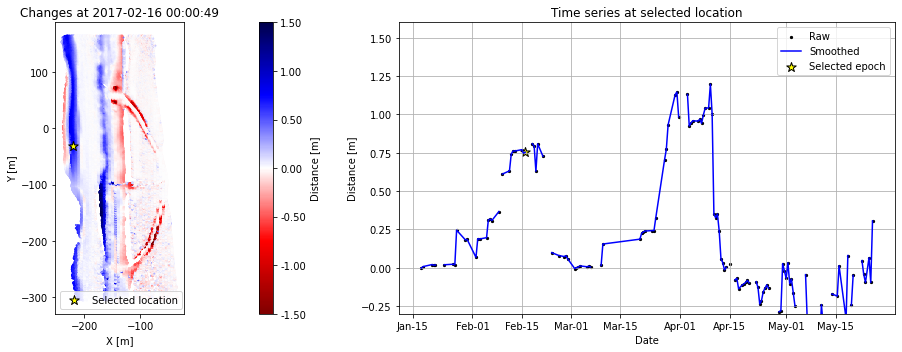

In [7]:
cp_idx_sel = 15162  # selected core point index
epoch_idx_sel = 28  # selected epoch index

# import plotting module
import matplotlib.pyplot as plt

# allow interactive rotation in notebook
%matplotlib inline

# create the figure
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# get the corepoints
corepoints = analysis.corepoints.cloud

# get change values of last epoch for all corepoints
distances = analysis.distances
distances_epoch = [d[epoch_idx_sel] for d in distances]

# get the time series of changes at a specific core point locations
coord_sel = analysis.corepoints.cloud[cp_idx_sel]
timeseries_sel = distances[cp_idx_sel]

# get the list of timestamps from the reference epoch timestamp and timedeltas
timestamps = [t + analysis.reference_epoch.timestamp for t in analysis.timedeltas]

# plot the scene
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    c=distances_epoch[:],
    cmap="seismic_r",
    vmin=-1.5,
    vmax=1.5,
    s=1,
    zorder=1,
)
plt.colorbar(d, format=("%.2f"), label="Distance [m]", ax=ax1, pad=0.15)

# add the location of the selected coordinate
ax1.scatter(
    coord_sel[0],
    coord_sel[1],
    facecolor="yellow",
    edgecolor="black",
    s=100,
    zorder=2,
    label="Selected location",
    marker="*",
)
ax1.legend()

# configure the plot layout
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_aspect("equal")
ax1.set_title(
    "Changes at %s"
    % (analysis.reference_epoch.timestamp + analysis.timedeltas[epoch_idx_sel])
)

# plot the time series
ax2.scatter(timestamps, timeseries_sel, s=5, color="black", label="Raw")
ax2.plot(timestamps, timeseries_sel, color="blue", label="Smoothed")
ax2.set_xlabel("Date")

# add the epoch of the plotted scene
ax2.scatter(
    timestamps[epoch_idx_sel],
    timeseries_sel[epoch_idx_sel],
    facecolor="yellow",
    marker="*",
    edgecolor="black",
    s=100,
    color="red",
    label="Selected epoch",
)
ax2.legend()

# format the date labels
import matplotlib.dates as mdates

dtFmt = mdates.DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(dtFmt)

# configure the plot layout
ax2.set_ylabel("Distance [m]")
ax2.grid()
ax2.set_ylim(-0.3, 1.6)
ax2.set_title("Time series at selected location")

plt.tight_layout()
plt.show()

The map of changes in the scene shows us linear structures of sand deposition near the coast which can be interpreted as sand bars (with knowledge about coastal processes). This is confirmed by the surface behavior over time, expressed in the time series plot. However, the time series is quite noisy especially in this part of the beach, which is regularly covered by water during high tides (leading to missing data) and also varies strongly in surface moisture (influencing the LiDAR range measurement and causing noise). We therefore continue with temporal smoothing of the time series.

## Principal component analysis

In the following, we will use principal component analysis (PCA; also referred to as empirical orthogonal functions) as a tool to summarize the change patterns within a spatiotemporal dataset. The method is based on [this master thesis](http://resolver.tudelft.nl/uuid:ce98c4e3-6ca1-4966-a5cf-2120f2fa44bf), to be published in [Frantzen et al. (2023)](#references). 
 
For this technique, the 4D data shall be represented as a two-dimensional array in which the rows correspond to different epochs, and the columns correspond to each individual [x, y] coordinate where a z or surface change value is represented. 

Reshape the data from the `SpatiotemporalAnalysis` object so that all coordinates are represented in one axis, i.e. an array holding [time, space]:

In [8]:
X = distances.transpose()

Find coordinates without nan values, and create a new array without nan values:

In [9]:
idxs = np.argwhere(
    ~np.isnan(X).any(axis=0)
)  # store the column indices where actual data is present
X_no_nan = X[:, idxs.flatten()].reshape((X.shape[0], -1))

Compute the loading and scores of the prinicpal components in 'NaN-free' X:

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
scores = pca.fit_transform(X_no_nan)
result = pca.components_

Plot the principal component loadings and scores along with their fraction of explained variance:

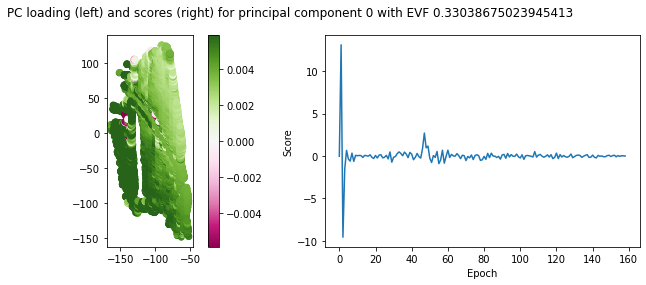

In [11]:
coords_no_nan = analysis.corepoints.cloud[idxs]
for i in range(1):  # range(pca.n_components_):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sat_val = (
        np.abs(np.nanpercentile(result[i], 10))
        + np.abs(np.nanpercentile(result[i], 90)) / 2
    )
    s = axes[0].scatter(
        coords_no_nan[:, 0, 0],
        coords_no_nan[:, 0, 1],
        c=result[i],
        clim=(-sat_val, sat_val),
        cmap="PiYG",
    )
    axes[0].set_aspect("equal")
    axes[1].plot(scores[i])
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    fig.suptitle(
        f"PC loading (left) and scores (right) for principal component {i} with EVF {pca.explained_variance_ratio_[i]}"
    )
    plt.colorbar(s, ax=axes[0])
    plt.tight_layout()
    fig.show()

<a id='references'></a>
# References

* Anders, K., Lindenbergh, R. C., Vos, S. E., Mara, H., de Vries, S., & Höfle, B. (2019). High-Frequency 3D Geomorphic Observation Using Hourly Terrestrial Laser Scanning Data Of A Sandy Beach. ISPRS Ann. Photogramm. Remote Sens. Spatial Inf. Sci., IV-2/W5, pp. 317-324. doi: [10.5194/isprs-annals-IV-2-W5-317-2019](https://doi.org/10.5194/isprs-annals-IV-2-W5-317-2019).
* Anders, K., Winiwarter, L., Mara, H., Lindenbergh, R., Vos, S. E., & Höfle, B. (2021). Fully automatic spatiotemporal segmentation of 3D LiDAR time series for the extraction of natural surface changes. ISPRS Journal of Photogrammetry and Remote Sensing, 173, pp. 297-308. doi: [10.1016/j.isprsjprs.2021.01.015](https://doi.org/10.1016/j.isprsjprs.2021.01.015).
* Frantzen, P., Voordendag, A., Kuschnerus, M., Rutzinger, M.,  Wouters, B., Lindenbergh, R. (2023, in review). Identifying Paraglacial Geomorphic Process Dynamics Using A Principal Component Analysis Of Terrestrial Laser Scanning Time Series.
* Vos, S., Anders, K., Kuschnerus, M., Lindenberg, R., Höfle, B., Aarnikhof, S. & Vries, S. (2022). A high-resolution 4D terrestrial laser scan dataset of the Kijkduin beach-dune system, The Netherlands.  Scientific Data, 9:191. doi: [10.1038/s41597-022-01291-9](https://doi.org/10.1038/s41597-022-01291-9).